This notebook will record the process of making synthetic bat call data, creating multiple FFT representations of it. 
I thought this would be a nice and flexible way to train the network because I need different FFt resolutions for different purposes ( call duration measurement(short window size), spectral analyses(bigger window size), shape analyses(medium window size)). It would be nice to have a network that is broadly trained on segmenting calls at multiple levels - so that i can take the same call, and segment it at multiple resolutions to get the data i need. 

The broad plan is to create synthetic data like I've been doing, but this time do it a bit more deliberately with the following types of training examples
* 1) single calls
* 2) >1 call
* 3) NO call

In [234]:
% matplotlib notebook

In [448]:
import matplotlib.pyplot as plt 
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pickle
import scipy.signal as signal 

from make_training_data import *

In [412]:
def calc_multi_windowsize_FFT(sound_sample, winsizes=[32,64,96]):
    ''' Calculates spectrogram with multiple FFT window sizes with 0 overlap, 0.01 Tukey window and no scaling.
    '''
    specs = {}
    for one_winlength in winsizes:
        _, _, Sxx = signal.spectrogram(sound_sample, fs=192000, window=('tukey',0.01), nperseg=one_winlength,
                                       noverlap=0, scaling='none' )
        specs[one_winlength] = np.flipud(Sxx)
    return(specs)

In [413]:
def extract_mask_from_specgm(specgm):
    ''' Extracts a mask by setting the threshold to 97th percentile value.
    '''
    threshold = np.percentile(specgm.flatten(), 97)
    mask = np.zeros(specgm.shape)
    mask[specgm>=threshold] = 1  
    return(mask)
    
def extract_multi_spec_masks(specgm_dict):
    
    multi_masks = {}
    for fft_winsize, specgm in specgm_dict.iteritems():
        multi_masks[fft_winsize] = extract_mask_from_specgm(specgm)
    
    return(multi_masks)
        
        

In [414]:
def get_specgms_and_masks(sample_sound,**kwargs):
    # take the spectrogram representations at multiple FFT window sizes
    if 'winsizes' in kwargs.keys():
        specs_sample = calc_multi_windowsize_FFT(sample_sound,kwargs['winsizes'])
    else:     
        specs_sample = calc_multi_windowsize_FFT(sample_sound)

    # get the masks for each of the spectrogram resolutions
    masks_sample = extract_multi_spec_masks(specs_sample)
    return(specs_sample, masks_sample)
    

An illustration of how the same call looks slightly different in each spectrogram because of the window size variation

<IPython.core.display.Javascript object>


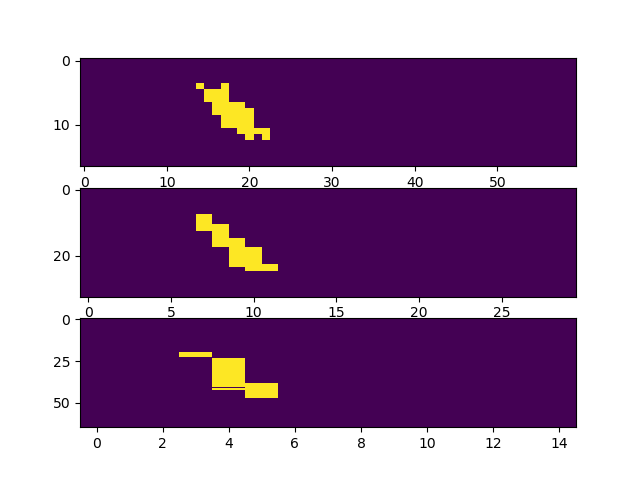

In [415]:
q = generate_a_samplesound(np.random.choice(np.arange(0.002,0.010),1),
                                           shape=np.random.choice(['linear', 'logarithmic'],1)[0],
                                           SNR=np.random.choice(np.arange(5,50), 1))
a = calc_multi_windowsize_FFT(q, [32,64,128])
u = extract_multi_spec_masks(a)
plt.figure()

plt.subplot(311)
plt.imshow(u[32],aspect='auto')
plt.subplot(312)
plt.imshow(u[64],aspect='auto')
plt.subplot(313)
plt.imshow(u[128],aspect='auto')

In [240]:
def make_single_call():
    '''
    '''
    sample = generate_a_samplesound(np.random.choice(np.arange(0.001,0.010),1),
                                           shape=np.random.choice(['linear', 'logarithmic'],1)[0],
                                           SNR=np.random.choice(np.arange(5,50), 1))
    
    specs_sample, masks_sample = get_specgms_and_masks(sample)
   
    
    return(sample, specs_sample, masks_sample)
    
    

In [416]:
def make_morethan1_call():
    ''' WARNING this can create very close by calls. I AM writing SLOPPY code right now - and so the network may 
    actually not learn to suppress echoes etc. 
    '''
    num_calls = int(np.random.choice(np.arange(2,4), 1))
    
    # make the required number of calls w their own shapes etc.
    sounds = [ generate_a_samplesound(np.random.choice(np.arange(0.001,0.010),1),
                                           shape=np.random.choice(['linear', 'logarithmic'],1)[0],
                                           SNR=np.random.choice(np.arange(5,50), 1)) for i in range(num_calls)]
    sounds_inarray = np.array(sounds)
    many_sounds = np.apply_along_axis(np.sum, 0, sounds_inarray)
    
    if np.max(many_sounds) >= 1:
        many_sounds *= 1/np.max(many_sounds)
        many_sounds *= 0.99
    
    specs_sample, masks_sample = get_specgms_and_masks(many_sounds)
    
    return(many_sounds, specs_sample, masks_sample)
    
    

<IPython.core.display.Javascript object>


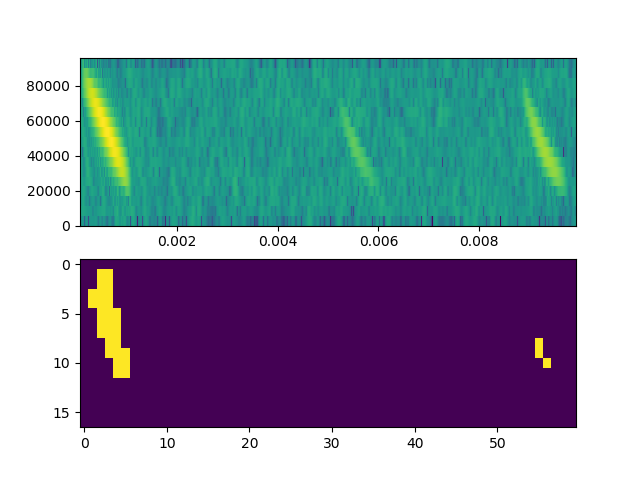

In [417]:
y,a,b= make_morethan1_call()
plt.figure()
plt.subplot(211)
plt.specgram(y, Fs=192000, NFFT=32, noverlap=31);
plt.subplot(212)
plt.imshow(b[32], aspect='auto')


In [339]:
def make_no_call():
    ''' creates 10ms (@192kHz FS) of a highpass filtered noise band with variable frequency bands between 20 - 90 KHz.
    '''
    white_noise  = np.random.normal(0,1,1920)
    
    #bandpass it between randomly chosen ferquencies
    high_freq, low_freq = np.arange(50000,90000), np.arange(0,45000)
    one_highfreq, one_lowfreq = np.random.choice(high_freq,1), np.random.choice(low_freq,1)
    filter_strength = np.random.choice(np.arange(1,4),1)
    nyq_freq = 192000/2.0
    bandpass_limits = np.array([one_lowfreq, one_highfreq])/nyq_freq
    b,a = signal.butter(filter_strength, bandpass_limits, 'bandpass' )
    bp_noise = signal.lfilter(b,a, white_noise)

    # normalise
    if np.max(bp_noise) >= 1:
        bp_noise *= 1/np.max(bp_noise)
        bp_noise *= 0.98
    
    specs_sample, masks_sample = get_specgms_and_masks(bp_noise)
    
    # alter the masks_sample to show NO 1's
    for resolution, mask  in masks_sample.iteritems():
        mask[:,:] = 0 
    
    return(bp_noise, specs_sample, masks_sample)


In [418]:
training_examples = {1: make_single_call,
                     2: make_morethan1_call,
                     3: make_no_call,
                    }


In [442]:
def generate_a_training_example(*args):
    ''' Outputs a 10 ms audio sample at 192 kHz that can be 
    1) a single call
    2) a snippet with NO call
    3) two or more calls 
    
    along with with their 32, 64, and 128 FFT window size spectrogram representations

    '''
    
    if len(args)>0:
        print(args[0])
        choice = int(args[0])
    else:
        choice = int(np.random.choice(np.arange(1,4),1))

    example_types = {1: 'single',
                 2: 'many',
                 3: 'nocall',
                }
    # create training example based on the random choice made 

    audio, specs, masks = training_examples[choice]()
    
    # generate a unique if for this particular file number 
    # thanks https://tinyurl.com/yclfd5st for multiprocessing adjustment tip
    unique_id = str(uuid.UUID(bytes=os.urandom(16), version=4))
    
    this_example_type = example_types[choice]
    
    example_dict = {}
    example_dict = {'sound': audio,
                               'specgms' : specs,
                               'masks' : masks,
                               'type' : this_example_type
                              }
        
    
    return(unique_id, example_dict)

And so, now let's make a decent number of these examples with training, validation and test datasets. 

In [447]:
%%time
# to ensure consistent creation of data sets 
np.random.seed(111)

num_training, num_validation, num_testing = 700, 200, 100
# generate training data
training = {}
for i in range(num_training):
    uid, training_sample = generate_a_training_example()
    training[uid] = training_sample

validation = {}
# geneate validation data 
for i in range(num_validation):
    uid, validation_sample = generate_a_training_example()
    validation[uid] = validation_sample

testing = {}
# generate test data
for i in range(num_testing):
    uid, test_sample = generate_a_training_example()
    testing[uid] = test_sample

CPU times: user 18.1 s, sys: 578 ms, total: 18.7 s
Wall time: 9.35 s


In [454]:
# begin to put the files into pickles so that we can continue onto the next notebook!
with open("sound_spec_mask/round_2/test_round2.pkl", "wb") as test_file:
    pickle.dump(testing, test_file)

with open(r'sound_spec_mask/round_2/training_round2.pkl','wb') as train_file:
    pickle.dump(training, train_file)

with open(r'sound_spec_mask/round_2/validation_round2.pkl','wb') as validn_file:
    pickle.dump(validation, validn_file)

    